## Setup and Helper Functions

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import transformers
import math
from transformers import ViTImageProcessor, ViTForImageClassification, AutoConfig

class Activation_Patch:
  def __init__(self):
    self.activations = {}
    self.activations['attention_heads'] = []
    self.activations['value_activations'] = []

  def __call__(self, patch_head, patch_activation, module, module_in, module_out):
    self.activations['input'] = (module_in)
    self.activations['output'] = (module_out)
    self.activations['key'] = module.key
    self.activations['query'] = module.query

    def transpose_for_scores(x: torch.Tensor) -> torch.Tensor:
      new_x_shape = x.size()[:-1] + (12, 64)
      x = x.view(new_x_shape)
      return x.permute(0, 2, 1, 3)

    key_activations = transpose_for_scores(module.key(module_in[0]))
    query_activations = transpose_for_scores(module.query(module_in[0]))
    value_activations = transpose_for_scores(module.value(module_in[0]))

    self.activations['value_activations'].append(value_activations)

    attention_scores = torch.matmul(query_activations, key_activations.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(64)
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)

    if isinstance(patch_activation, torch.Tensor):
      attention_probs[:,patch_head,:,:] = patch_activation
      self.activations['patching_done'] = True
    else:
      self.activations['patching_done'] = False

    self.activations['attention_heads'].append(attention_probs)

    # Mask heads if we want to
    if module_in[1] is not None:
        attention_probs = attention_probs * module_in[1]

    context_layer = torch.matmul(attention_probs, value_activations)

    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (12*64,)
    context_layer = context_layer.view(new_context_layer_shape)

    outputs = (context_layer, attention_probs) if module_in[2] else (context_layer,)

    return outputs

  def clear(self):
    self.activations = {}

## Collecting activations with a forward pass

In [ ]:
from functools import partial
from torchvision.io import read_image

patch = Activation_Patch()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

for module in model.modules():
  if isinstance(module, transformers.models.vit.modeling_vit.ViTSelfAttention):
    module.register_forward_hook(partial(patch, False, False))

dog_img = read_image('dog.jpg')
process = ViTImageProcessor()

dog_img = process(dog_img, return_tensors='pt')['pixel_values']

with torch.no_grad():
    dog_logits = model(dog_img)

dog_activation_heads = patch.activations['attention_heads']
value_activation_heads = patch.activations['value_activations']
patch.clear()

In [ ]:
dog_activations = torch.zeros(12,12,197,197)
value_activations = torch.zeros(12,12,197,64)
for i in range(12):
  dog_activations[i] = dog_activation_heads[i]
  value_activations[i] = value_activation_heads[i]

## Attention Pattern visualisation

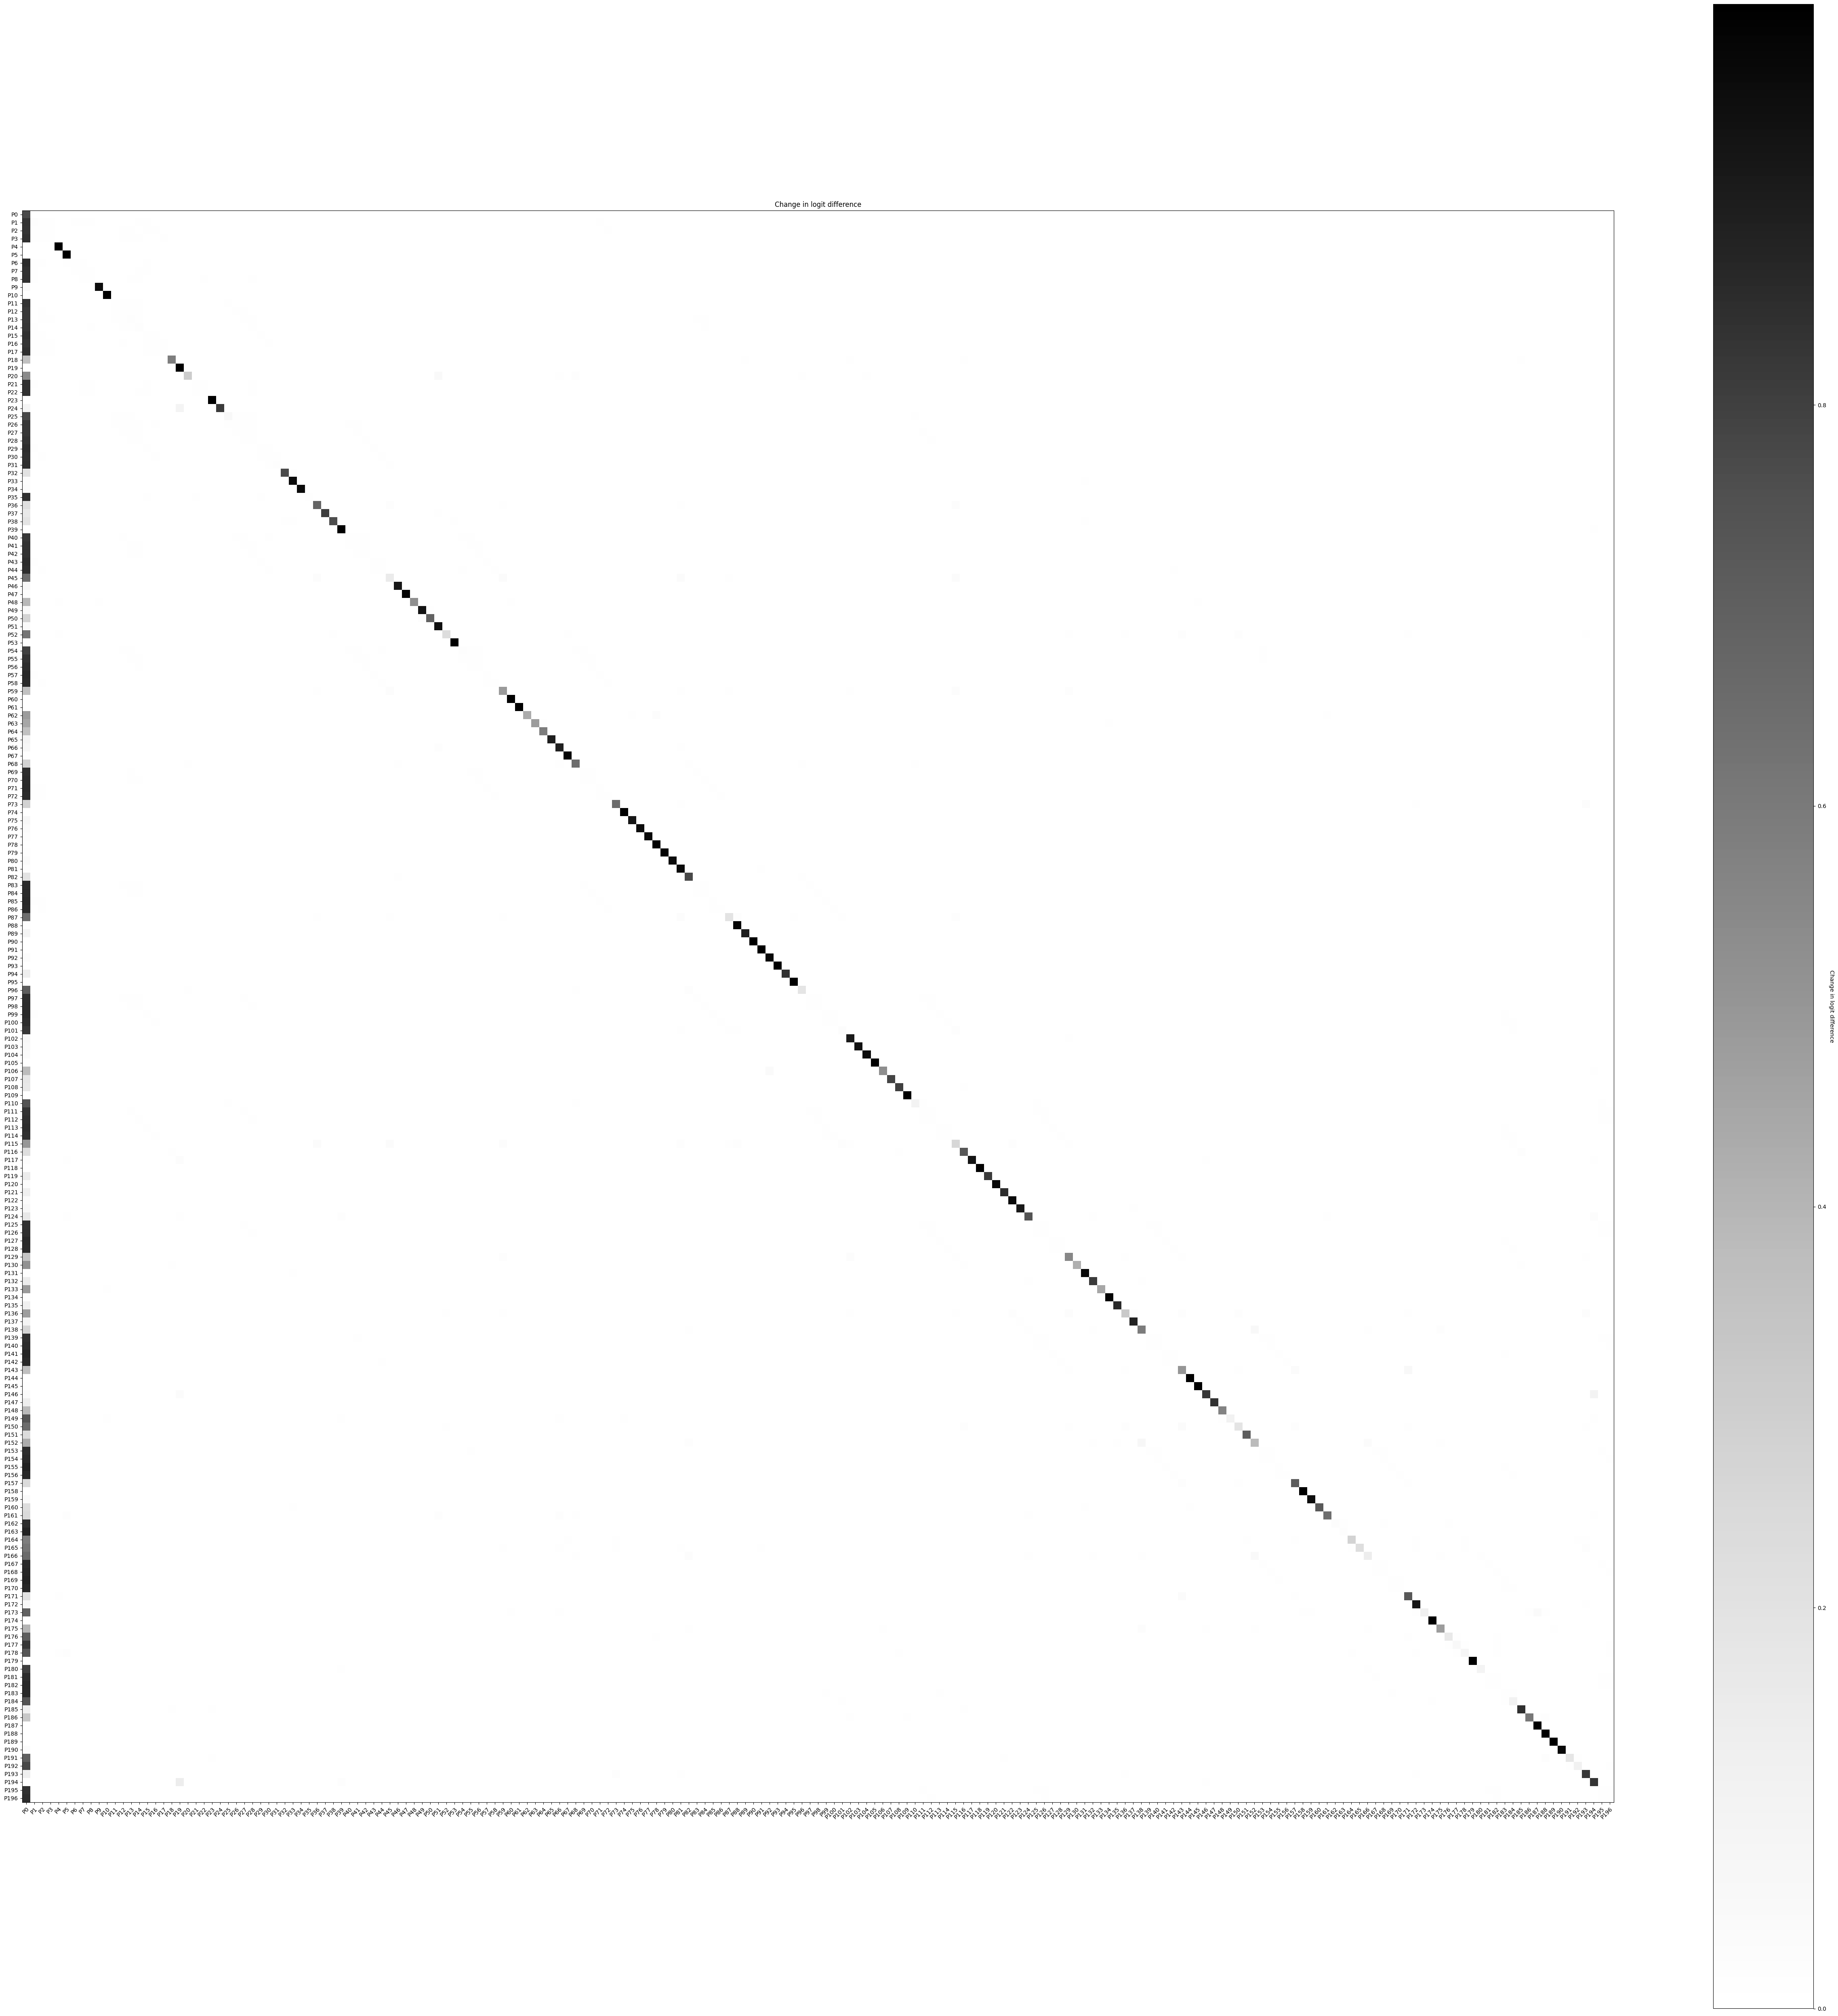

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

patches = [f'P{i}' for i in range(197)]
layers = [f'L{i}' for i in range(12)]
heads = [f'H{i}' for i in range(12)]

layer = 0 # Change this to see activation patterns for different layers (0-11)
head = 0 # Change this to see activation patterns for different heads (0-11)

change_in_logit_difference = np.asarray(dog_activations[layer,head,:,:])

fig, ax = plt.subplots(figsize=(50,50))
im = ax.imshow(change_in_logit_difference, cmap = 'Greys')

ax.set_yticks(np.arange(len(patches)), labels=patches)
ax.set_xticks(np.arange(len(patches)), labels=patches)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Change in logit difference', rotation=-90, va="bottom")

ax.set_title("Change in logit difference")
fig.tight_layout()

plt.show()

## Value-normed attention

In [ ]:
import einops
value_normed = einops.repeat(value_activations.norm(dim=3), 'a b c -> a b repeat c', repeat=197)
max_values_per_head = einops.repeat(value_normed.max(dim=3).values, 'a b c -> a b repeat c', repeat=197)
value_normalised = value_normed/max_values_per_head
normed_attention = value_normalised * dog_activations

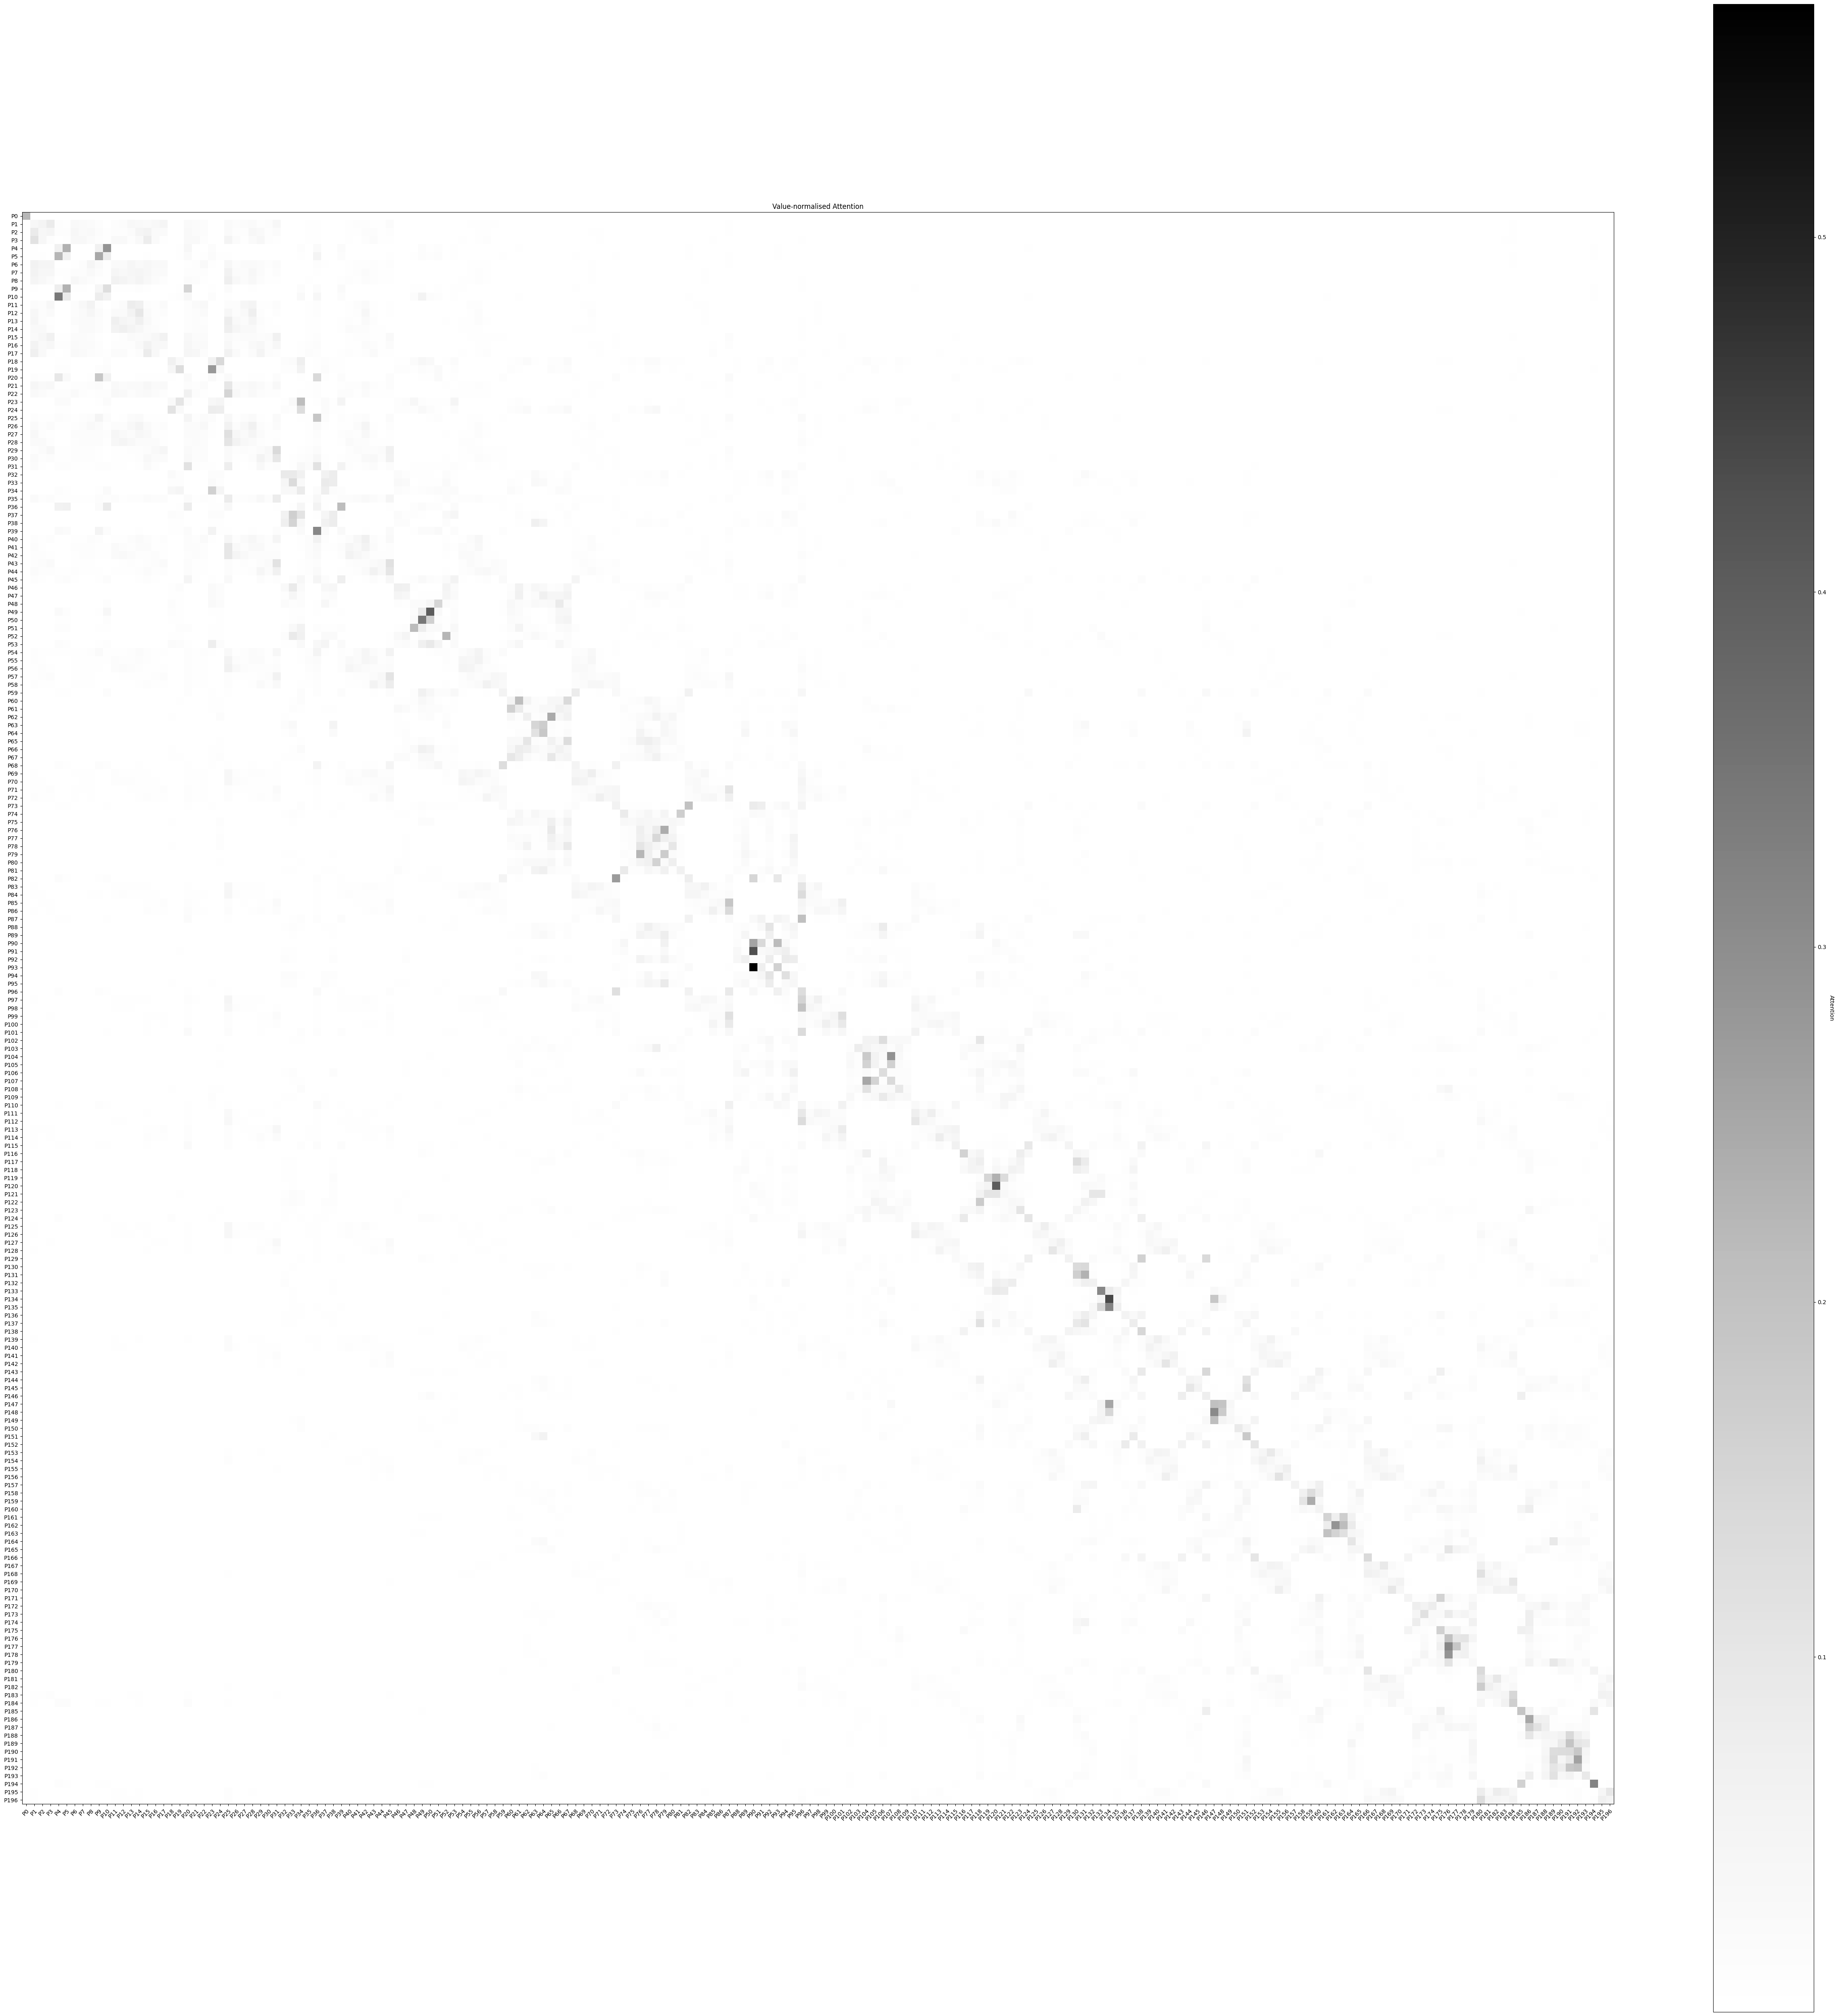

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

patches = [f'P{i}' for i in range(197)]
layers = [f'L{i}' for i in range(12)]
heads = [f'H{i}' for i in range(12)]

layer = 1
head = 5

fig, ax = plt.subplots(figsize=(50,50))
im = ax.imshow(normed_attention[layer, head, :, :], cmap = 'Greys')

ax.set_yticks(np.arange(len(patches)), labels=patches)
ax.set_xticks(np.arange(len(patches)), labels=patches)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Attention', rotation=-90, va="bottom")

ax.set_title("Value-normalised Attention")
fig.tight_layout()

plt.show()

## Aligning patches to images

In [ ]:
def convert_patch_to_coordinates(patch):

  patch_size = (16, 16)
  image_size = (224, 224)

  x = (patch % 14) * 16
  y = (patch // 14) * 16

  return x, y

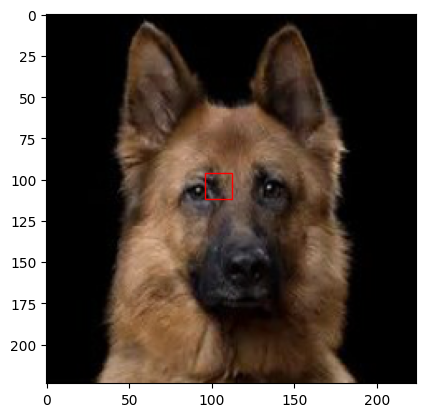

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

img = np.array(Image.open('/content/dog.jpg').resize((224,224)), np.float32)
img = img / 255
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch

x, y = convert_patch_to_coordinates(90)
#rect = patches.Rectangle((0, 0), 16, 16, linewidth=1, edgecolor='r', facecolor='none')

rect = patches.Rectangle((x,y), 16, 16, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

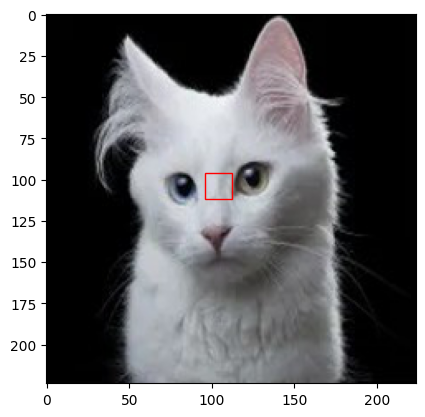

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

img = np.array(Image.open('/content/cat.jpg').resize((224,224)), np.float32)
img = img / 255
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch

x, y = convert_patch_to_coordinates(90)
#rect = patches.Rectangle((0, 0), 16, 16, linewidth=1, edgecolor='r', facecolor='none')

rect = patches.Rectangle((x,y), 16, 16, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()